<a href="https://colab.research.google.com/github/noFAYZ/p176056/blob/main/OUTBREAKPREDICTION_SARIMAX_FYP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid-19 Outbreak prediction by Time Series Analysis using Twitter Data**
Time series forecasting using SARIMAX and Auto TS.
Outbread Detection using exponential approach

# **Libraries and Data import**

In [ ]:
!pip install wget
import gzip
import shutil
import os
import wget
import csv
import linecache
from shutil import copyfile
import ipywidgets as widgets
import numpy as np
import pandas as pd


In [4]:
def readFile(fileName):
    fileObj = open(fileName, "r") #opens the file in read mode
    words = fileObj.read().splitlines() #puts the file into an array
    fileObj.close()
    return words
from urllib.parse import urlparse
def get_filename(url):
    a=urlparse(url)
    fname=os.path.basename(a.path)
    return os.path.splitext(fname)[0]

def get_filenameext(url):
    a=urlparse(url)
    fname=os.path.basename(a.path)
    return fname

In [10]:
dataframe = pd.read_csv('PakistanSorted.csv', usecols=[0,1], engine='python')
dataframe['ds'] = pd.to_datetime(dataframe['ds'])
dataframe = dataframe.sort_values('ds',ascending=True)
dataframe.reset_index(drop=True, inplace=True)
dataframe.head()


,ds,y
0,2020-07-26,60
1,2020-07-27,82
2,2020-07-28,90
3,2020-07-29,74
4,2020-07-30,106


In [12]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=dataframe['ds'], y=dataframe['y'])])
fig.show()

# **Decomposition & Analysis**

In [ ]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 6
plt.style.use('fivethirtyeight')

In [14]:
dataframe['y']=dataframe['y'].astype(float)
indexedDataset = dataframe.set_index(['ds'])

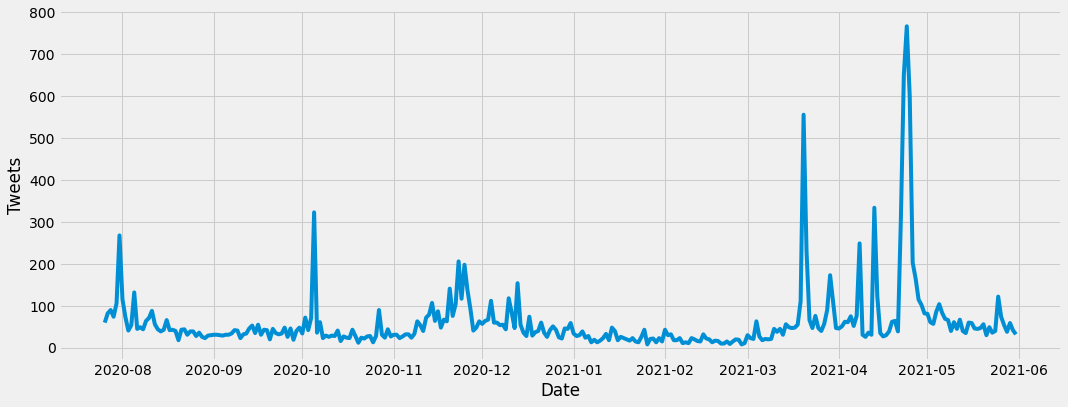

In [15]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.plot(indexedDataset)

In [16]:

rolmean = indexedDataset.rolling(window=24).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=24).std()
print(rolmean,rolstd)

                    y
ds                   
2020-07-26        NaN
2020-07-27        NaN
2020-07-28        NaN
2020-07-29        NaN
2020-07-30        NaN
...               ...
2021-05-27  58.916667
2021-05-28  56.916667
2021-05-29  55.041667
2021-05-30  53.333333
2021-05-31  51.791667

[310 rows x 1 columns]                     y
ds                   
2020-07-26        NaN
2020-07-27        NaN
2020-07-28        NaN
2020-07-29        NaN
2020-07-30        NaN
...               ...
2021-05-27  22.467206
2021-05-28  22.084653
2021-05-29  19.694358
2021-05-30  18.927015
2021-05-31  19.101512

[310 rows x 1 columns]


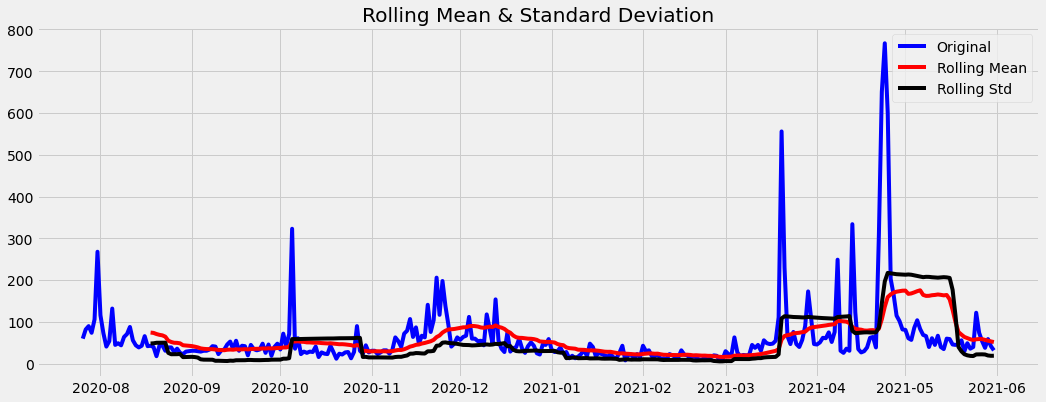

In [17]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [19]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['y'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -7.719197e+00
p-value                        1.205271e-11
#Lags Used                     1.000000e+00
Number of Observations Used    3.080000e+02
Critical Value (1%)           -3.451761e+00
Critical Value (5%)           -2.870970e+00
Critical Value (10%)          -2.571794e+00
dtype: float64


In [21]:
df7=dataframe
df7['ds'] = pd.to_datetime(df7['ds'])
df7 = df7.set_index('ds')
df7 = df7['2020-07-26':'2021-05-31'].resample('D').sum()

df7.head()

,y
ds,
2020-07-26,60.0
2020-07-27,82.0
2020-07-28,90.0
2020-07-29,74.0
2020-07-30,106.0


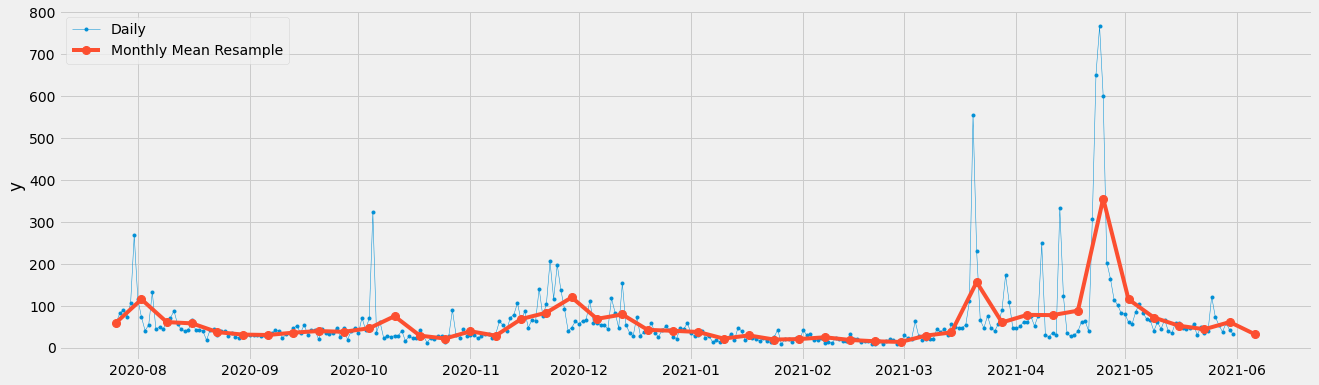

In [24]:
import warnings
import matplotlib.pyplot as plt
y = df7['y']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('y')
ax.legend();

In [25]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(13,7)
    plt.show()

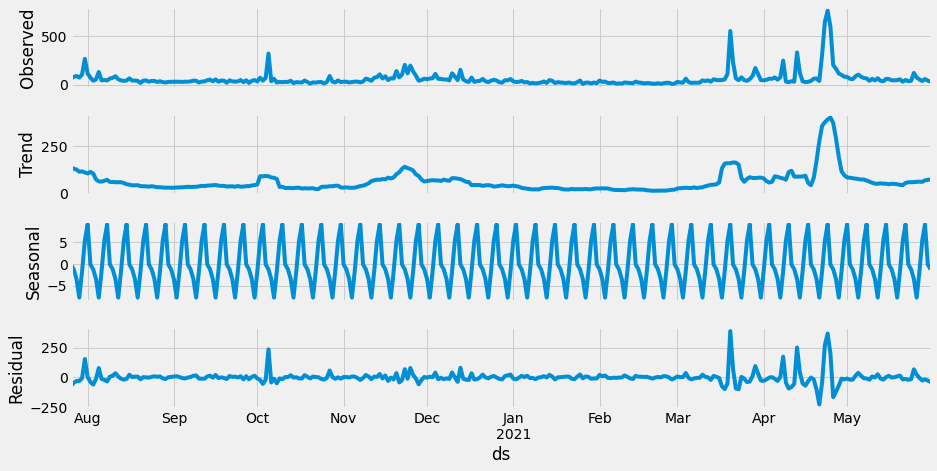

In [26]:
seasonal_decompose(y)


In [30]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

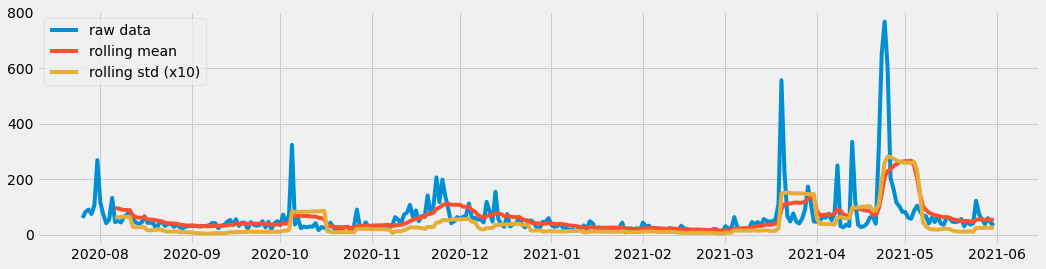

In [31]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [32]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [33]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -7.719
P-value = 0.000
Critical values :
	1%: -3.45176116018037 - The data is  stationary with 99% confidence
	5%: -2.870970093607691 - The data is  stationary with 95% confidence
	10%: -2.571794416006072 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -6.928
P-value = 0.000
Critical values :
	1%: -3.452636878592149 - The data is  stationary with 99% confidence
	5%: -2.8713543954331433 - The data is  stationary with 95% confidence
	10%: -2.5719993576515705 - The data is  stationary with 90% confidence


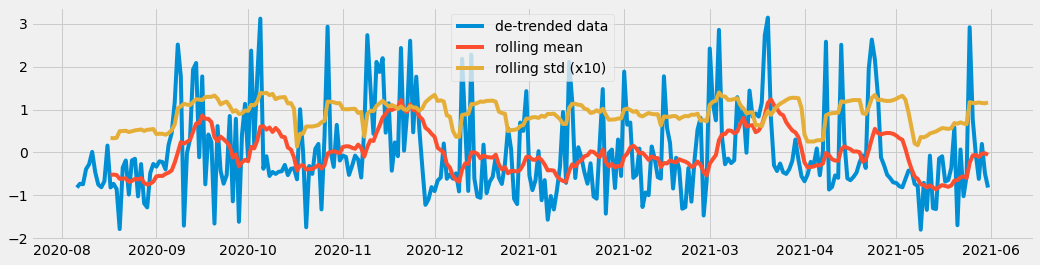

In [34]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -5.437
P-value = 0.000
Critical values :
	1%: -3.4535050041524245 - The data is  stationary with 99% confidence
	5%: -2.8717352599720294 - The data is  stationary with 95% confidence
	10%: -2.5722024776854417 - The data is  stationary with 90% confidence


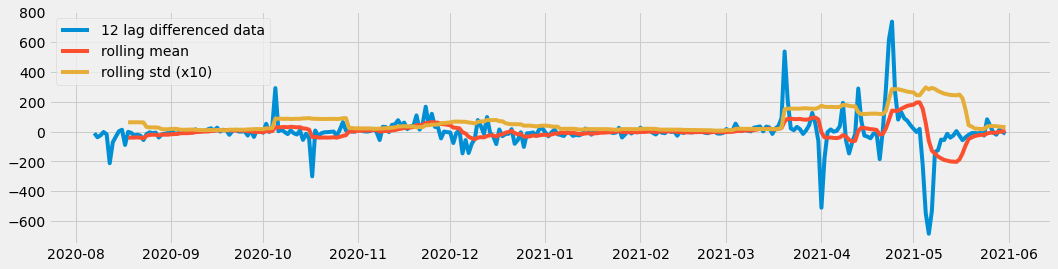

In [35]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -5.830
P-value = 0.000
Critical values :
	1%: -3.4544435065994437 - The data is  stationary with 99% confidence
	5%: -2.8721468827772774 - The data is  stationary with 95% confidence
	10%: -2.572422013959188 - The data is  stationary with 90% confidence


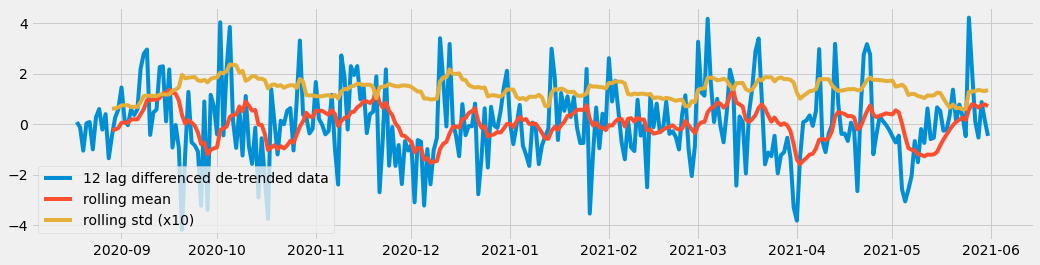

In [36]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [38]:
y_to_train = y[:295] # dataset to train
y_to_val = y[295:] # last X months for test  
predict_date = len(y) - len(y[:295]) # the number of data points for the test set

In [39]:
print(predict_date)
y_to_val.head(20)

15


ds
2021-05-17    46.00000000
2021-05-18    45.00000000
2021-05-19    47.00000000
2021-05-20    56.00000000
2021-05-21    30.00000000
2021-05-22    49.00000000
2021-05-23    36.00000000
2021-05-24    40.00000000
2021-05-25   122.00000000
2021-05-26    74.00000000
2021-05-27    54.00000000
2021-05-28    38.00000000
2021-05-29    59.00000000
2021-05-30    42.00000000
2021-05-31    32.00000000
Freq: D, Name: y, dtype: float64

# **SARIMAX**

In [40]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 1 is 23.13
The Root Mean Squared Error of our forecasts with auto optimization is 23.05


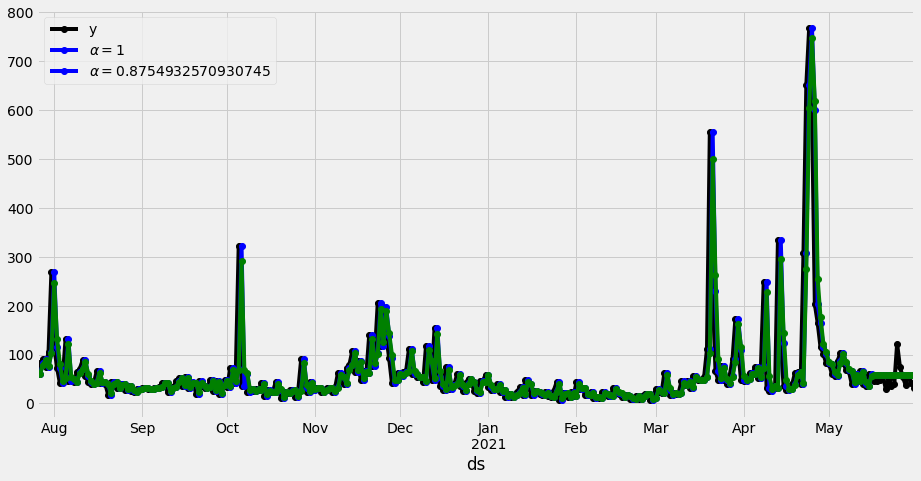

In [41]:
ses(y, y_to_train,y_to_val,1,predict_date)

In [42]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [43]:
sarima_grid_search(y,70)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dis

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 0, 70) - AIC:1956.1894881014173


In [44]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_invertibility=False,
                                   enforce_seasonabilty=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Tweets')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6347      0.045     13.983      0.000       0.546       0.724
ma.L1         -0.9746      0.025    -38.374      0.000      -1.024      -0.925
ar.S.L70      -0.4667      0.039    -12.059      0.000      -0.543      -0.391
sigma2      5433.1600    187.969     28.904      0.000    5064.747    5801.573


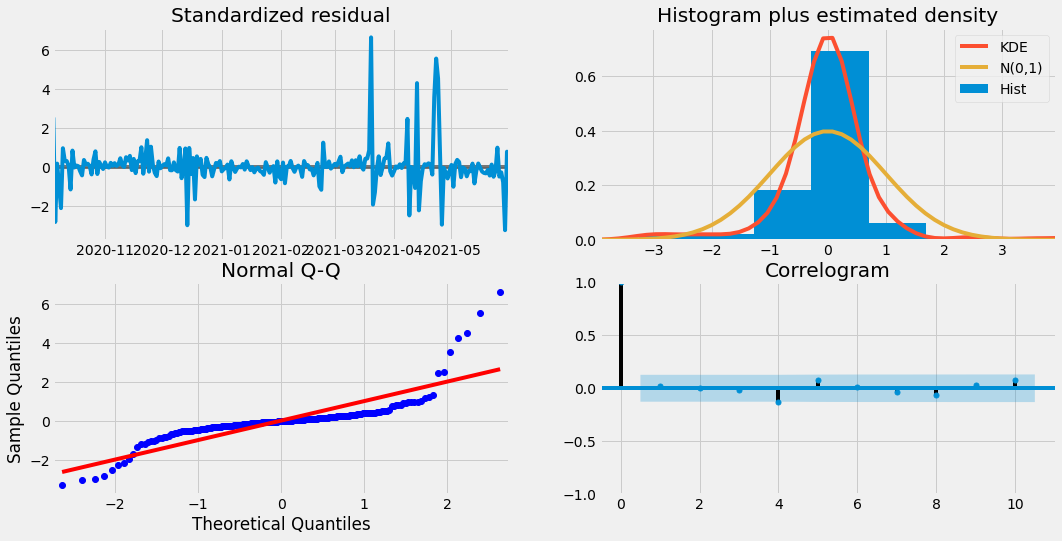

The Root Mean Squared Error of SARIMA with season_length=70 and dynamic = False 71.46


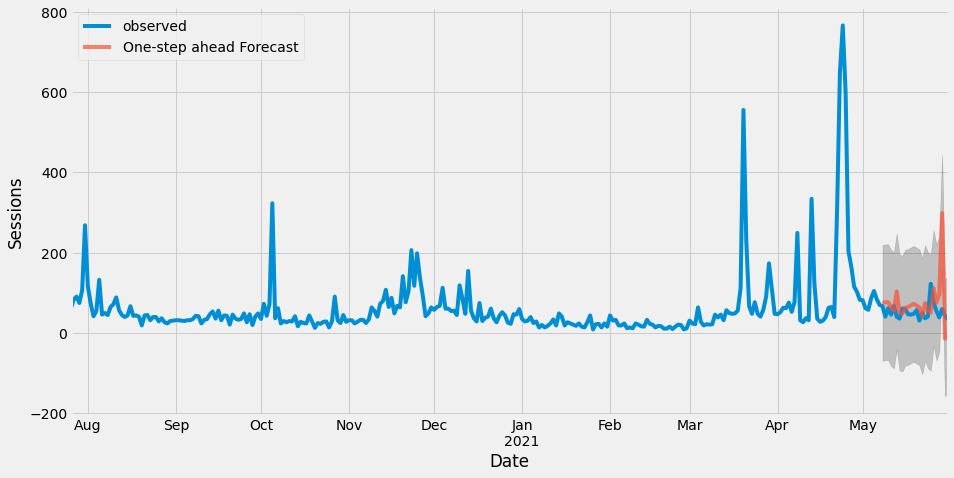

The Root Mean Squared Error of SARIMA with season_length=70 and dynamic = True 105.04


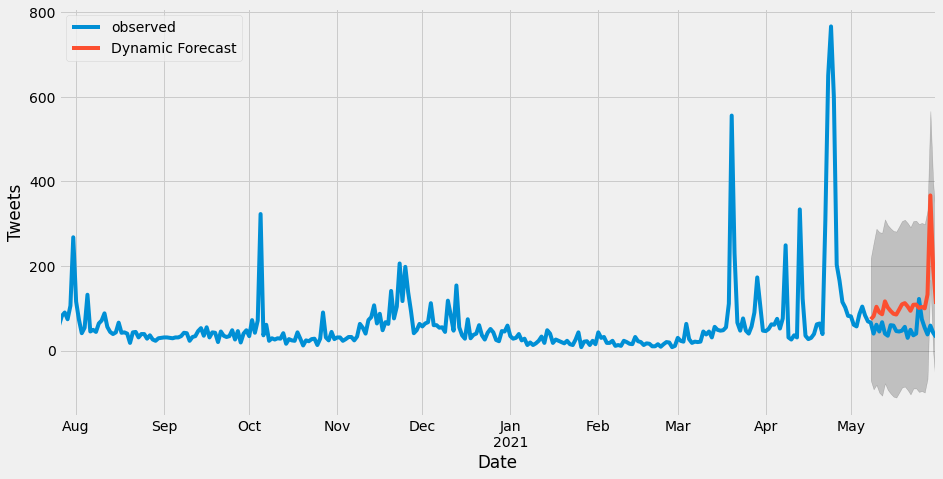

In [45]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 70),70,'2021-05-08',y_to_val)

In [46]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.20)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

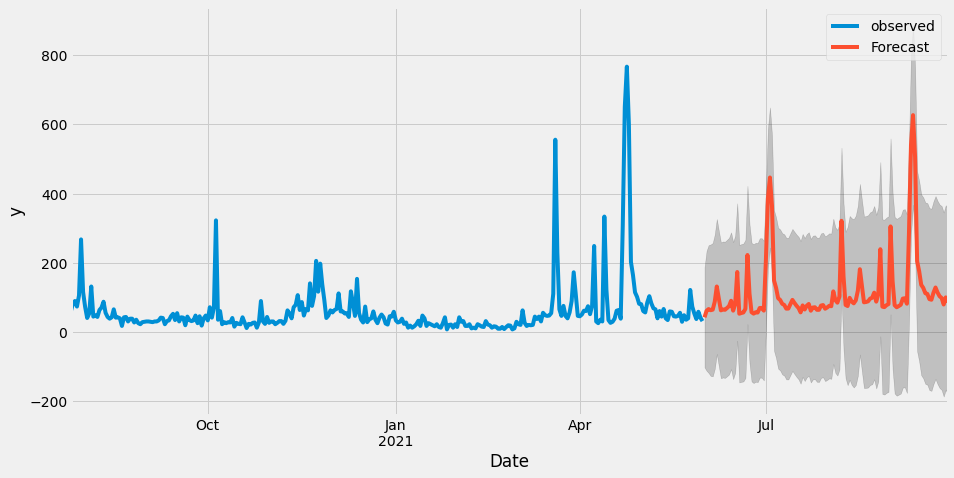

In [49]:
final_table = forecast(model,120,y)

In [61]:
final_table.head()

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-06-01,42.86630681,-101.60275126,187.33536487
1,2021-06-02,61.70029618,-111.40543085,234.80602322
2,2021-06-03,66.81362450,-117.81209538,251.43934438
3,2021-06-04,63.52366426,-126.36861957,253.41594809
4,2021-06-05,64.97493423,-127.57065529,257.52052375


# **AUTO TS**

In [ ]:
#######################################################AUTOML################################################################
#
#
#                                                     Auto TS 
#
############################################################################################################################
!pip install auto_ts
df9=df7
from auto_ts import auto_timeseries

train_df = df9.iloc[:295]
test_df = df9.iloc[295:]

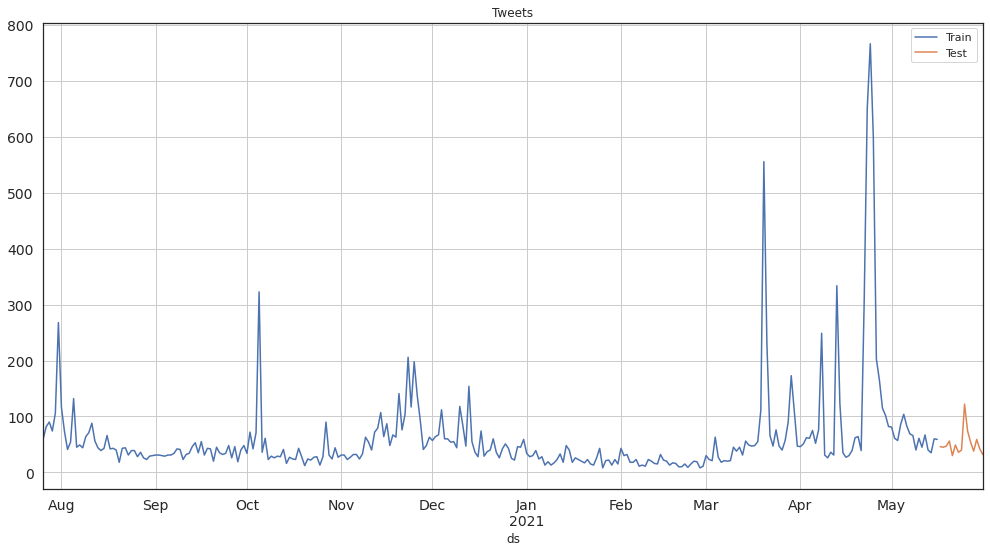

In [54]:
train_df.y.plot(figsize=(15,8), title= 'Tweets', fontsize=14, label='Train')
test_df.y.plot(figsize=(15,8), title= 'Tweets', fontsize=14, label='Test')
plt.legend()
plt.grid()
plt.show()

Start of Fit.....
    Target variable given as = Tweets
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: Date sep: , target: Tweets
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (295, 1)
No time series plot since verbose = 0. Continuing
Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
(Error): You have not provided the time_column values. This will result in an error
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Lowering forecast period to 49 to enable cross_validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 50 Test Shape: 49
    Root Mean Squared Error predictions vs actuals = 82.18
    Std Deviation of actuals = 43.40
    Normalized RMSE = 189%
Cros

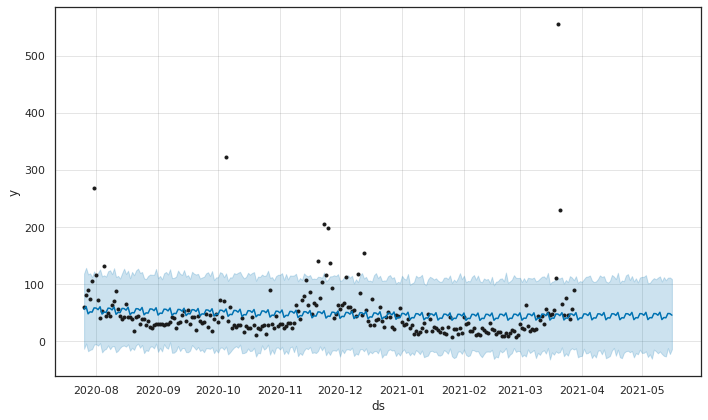

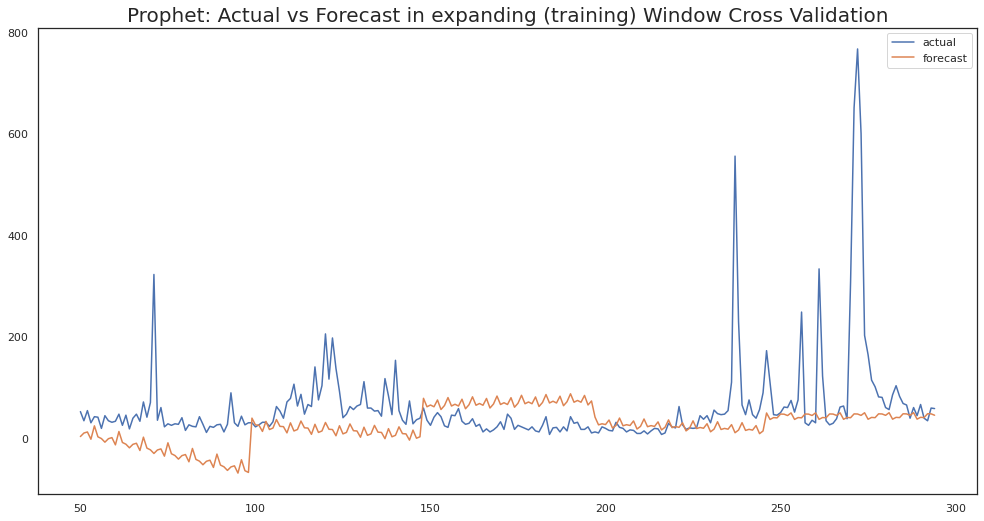

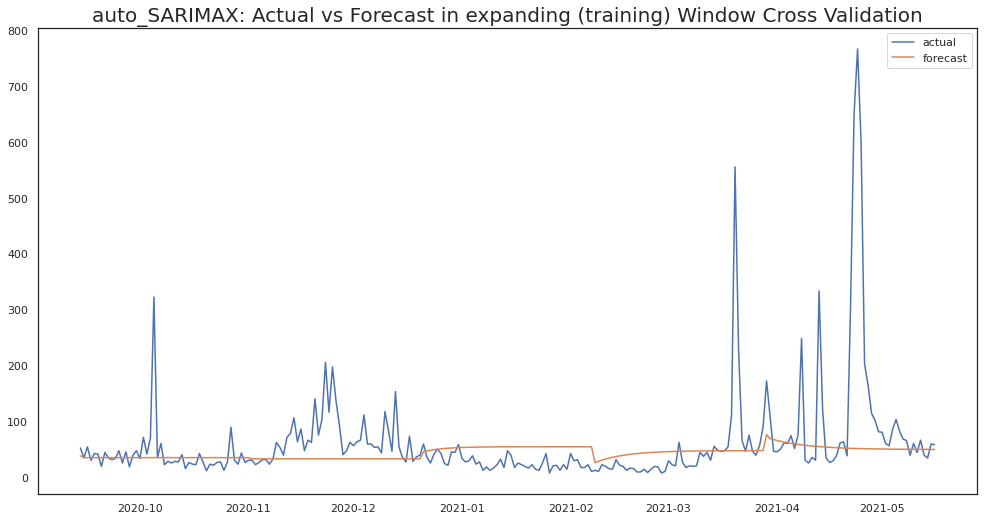

In [55]:
model = auto_timeseries(forecast_period=120, score_type='rmse', time_interval='D', model_type='best')
model.fit(traindata= train_df, ts_column="Date", target="Tweets")

In [56]:
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,75.98359462
0,Prophet,91.60685578
2,VAR,inf
3,ML,inf


In [57]:
future_predictions = model.predict(test_df)

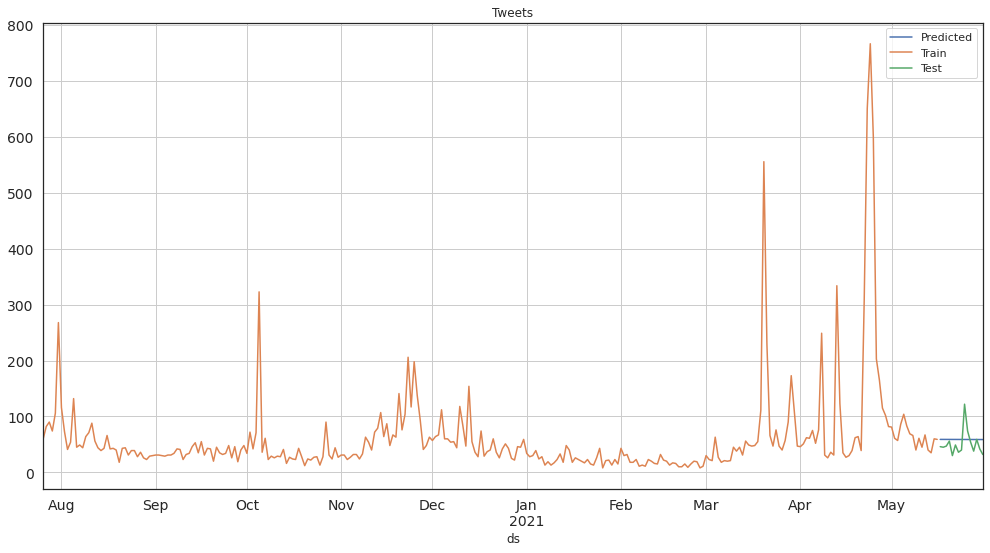

In [59]:
future_predictions.yhat.plot(figsize=(15,8), title= 'Tweets', fontsize=14, label='Predicted')
train_df.y.plot(figsize=(15,8), title= 'Tweets', fontsize=14, label='Train')
test_df.y.plot(figsize=(15,8), title= 'Tweets', fontsize=14, label='Test')
plt.legend()
plt.grid()
plt.show()